In [1]:
import sys
sys.path.append('../src/')

In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

from torch_geometric import seed_everything

import numpy as np
import pandas as pd

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from tqdm import tqdm

from models import LinkGIN, LinkGCN, LinkSAGE, DeepVGAE
from decoders import InnerProductDecoder, CosineDecoder
from explainers import gnnexplainer, ig, deconvolution, backprop
from metrics import deletion_curve_edges, deletion_curve_features, linear_area_score
from utils import ws_graph_model, sbm_graph_model, get_computation_graph_as_nx
from utils import get_explanation
from plotting import visualize_explanation

from torch_geometric.utils import k_hop_subgraph

from matplotlib import pyplot as plt
import seaborn as sb

In [3]:
sb.set_theme(context='paper', style='white', font_scale=1.5, palette=None)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

graph_model = 'cora'
model_name = 'gin'
explainer = 'ig'
decoder = 'cosine'
seed = 0

if model_name == 'vgae':
    sigmoid = False
else:
    sigmoid = True

if model_name == 'vgae':
    return_type = 'probs'
    from train_test import train_vgae as train
    from train_test import test_vgae as test
else:
    return_type = 'raw'
    from train_test import train
    from train_test import test
    
print(seed, graph_model, model_name, explainer, decoder, return_type)  

0 cora gin ig cosine raw


In [5]:
seed_everything(seed)


transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True),
])

dataset = graph_model.capitalize()
path = osp.join('../', 'data', 'Planetoid')
dataset = Planetoid(path, dataset, transform=transform)
train_data, val_data, test_data = dataset[0]

In [6]:
seed_everything(seed)
if model_name == 'gin':
    model = LinkGIN(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 61
if model_name == 'gcn':
    model = LinkGCN(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 201
if model_name == 'sage':
    model = LinkSAGE(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 101
if model_name == 'vgae':
    if decoder == 'inner':
        model = DeepVGAE(train_data.num_features, 128, 64, InnerProductDecoder()).to(device)
    if decoder == 'cosine':
        model = DeepVGAE(train_data.num_features, 128, 64, CosineDecoder()).to(device)
    tot_epochs = 2001

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

seed_everything(0)
for epoch in range(1, tot_epochs):
    loss = train(model, optimizer, train_data)
    if epoch % 20 == 0:
        if model_name == 'vgae':
            val_auc = test(model, train_data, val_data)
            test_auc = test(model, train_data, test_data)
        else:
            val_auc = test(model, val_data)
            test_auc = test(model, test_data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

Epoch: 20, Loss: 0.6199, Val: 0.6495, Test: 0.6294
Epoch: 40, Loss: 0.5394, Val: 0.7818, Test: 0.7566
Epoch: 60, Loss: 0.5146, Val: 0.7911, Test: 0.7751


In [7]:
i = 1
edge_label_index = val_data.edge_label_index[:, [i]]
source_node, target_node = edge_label_index.numpy()[:, 0]

target = val_data.edge_label[i].item()
if sigmoid:
        pred = model(train_data.x, train_data.edge_index, edge_label_index).sigmoid().item()
else:
    pred = model(train_data.x, train_data.edge_index, edge_label_index).item()

if target==1 and int(pred>0.5)==target:
    source_node, target_node, pred, target

    explanation, edge_mask, node_mask = get_explanation(
        explainer, model, train_data, edge_label_index, return_type=return_type
    )

    computation_graph = get_computation_graph_as_nx(source_node, target_node, train_data)

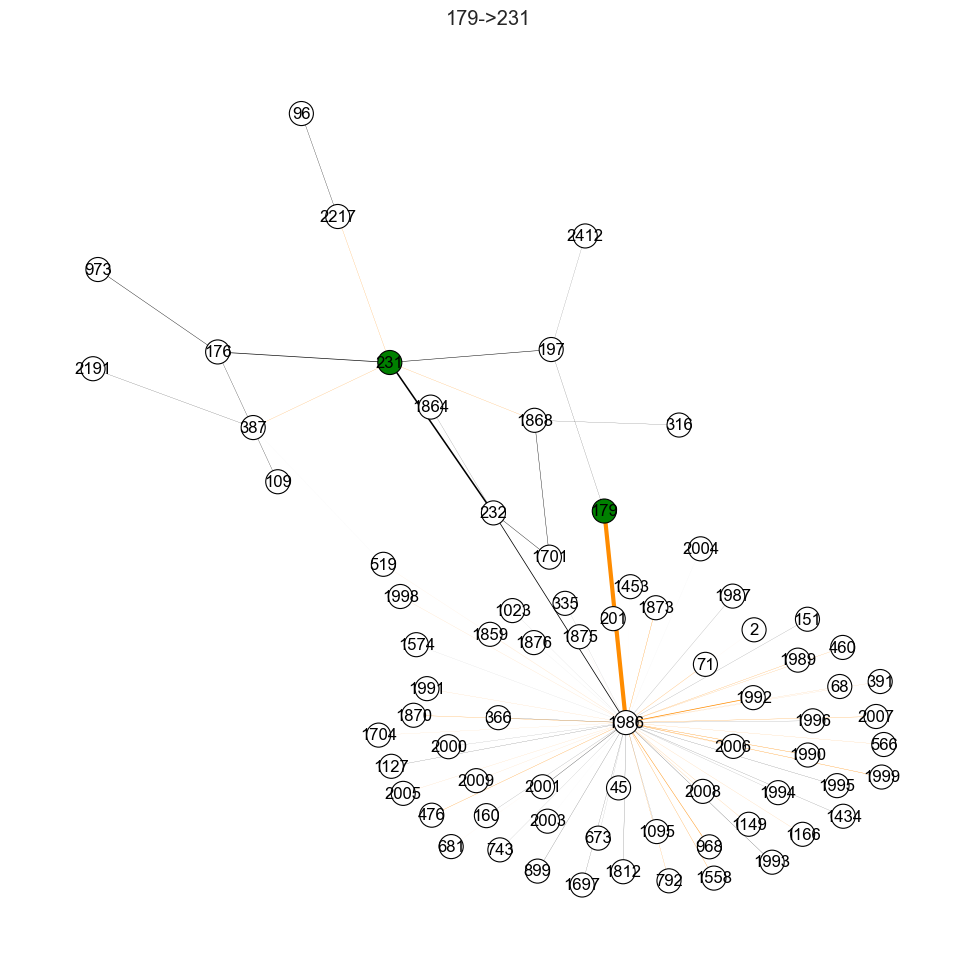

In [8]:
fig = visualize_explanation(computation_graph, train_data.edge_index, edge_mask, source_node, target_node)
plt.tight_layout()
plt.savefig(f"../paper/figs/{graph_model}_{model_name}_{explainer}_{decoder}_explanation_example.png")

In [9]:
subset, sub_edge_index, sub_mapping, sub_edge_mask = k_hop_subgraph(
        [source_node, target_node], 
        2, 
        train_data.edge_index)

#  Edges
deletion_curve = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    sigmoid=sigmoid
)

#  Edges random
deletion_curve_rnd = deletion_curve_edges(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    edge_mask[sub_edge_mask],
    sigmoid=sigmoid,
    sorting='random'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:56<00:00,  2.84s/it]


In [10]:
edge_score = linear_area_score(deletion_curve)

In [11]:
edge_score

0.5420408624775718

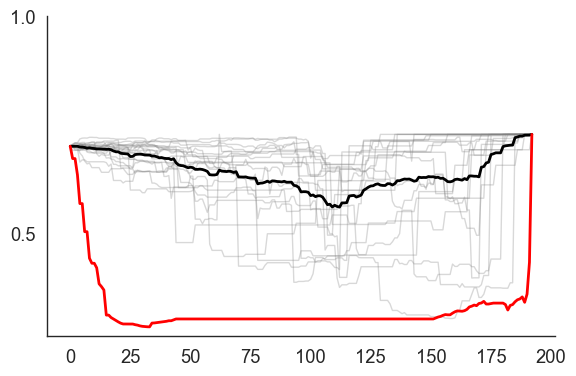

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(deletion_curve_rnd.T, alpha=.3, c='grey', lw=1)
plt.plot(deletion_curve_rnd.mean(axis=0), c='black', lw=2)
plt.plot(deletion_curve, c='r', lw=2)
ax.set_yticks([0.5, 1])
sb.despine()
plt.tight_layout()

In [13]:
#  Features / Nodes
feature_mean_mask = node_mask.mean(axis=0)
node_mean_mask = node_mask.mean(axis=1)
feature_base_values = train_data.x.mean(dim=0)

feature_deletion_curve = deletion_curve_features(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    sigmoid=sigmoid
)

#  Features / Nodes
feature_mean_mask = node_mask.mean(axis=0)
node_mean_mask = node_mask.mean(axis=1)
feature_base_values = train_data.x.mean(dim=0)

feature_deletion_curve_rnd = deletion_curve_features(
    model,
    train_data.x,
    sub_edge_index,
    edge_label_index,
    feature_mean_mask,
    feature_base_values,
    sigmoid=sigmoid, 
    sorting='random'
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [06:19<00:00, 18.99s/it]


In [14]:
feature_score = linear_area_score(feature_deletion_curve)

In [15]:
feature_score

0.5627308208978637

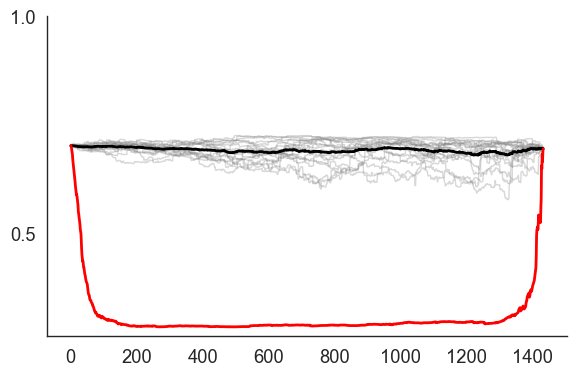

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
plt.plot(feature_deletion_curve_rnd.T, alpha=.3, c='grey', lw=1)
plt.plot(feature_deletion_curve_rnd.mean(axis=0), c='black', lw=2)
plt.plot(feature_deletion_curve, c='r', lw=2)
ax.set_yticks([0.5, 1])
sb.despine()
plt.tight_layout()